In [5]:
# https://github.com/leekyuyoung202306/PYTHON/tree/main/18주차
# 에서 utils.py  vae_utils.py를 import 하기위해 파일을 가져온다

In [ ]:
!unzip '/content/drive/MyDrive/celeba_face/img_align_celeba.zip' -d celeba_face

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras import layers,models,callbacks,utils,metrics,losses,optimizers
from scipy.stats import norm
import pandas as pd
from utils import sample_batch,display
from vae_utils import get_vector_from_label,add_vector_to_images,morph_faces

In [4]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [15]:
import glob
img_lists = glob.glob('/content/celeba_face/img_align_celeba/*')
img_lists[:3]

['/content/celeba_face/img_align_celeba/100828.jpg',
 '/content/celeba_face/img_align_celeba/110183.jpg',
 '/content/celeba_face/img_align_celeba/112271.jpg']

In [8]:
# 데이터 로드
train_data = utils.image_dataset_from_directory(
    "/content/celeba_face/img_align_celeba",
    labels = None,
    color_mode = 'rgb',
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation = 'bilinear'
)

Found 202599 files belonging to 1 classes.


In [21]:
# 전처리
def preprocess(img):
  img = tf.cast(img,'float32') / 255.0
  return img

train = train_data.map(lambda x : preprocess(x))

In [ ]:
# 패선 mnist와 얼굴데이터의 차이
# 채널 개수 1->3  디코더의 마지막 전치 합성곱 층의 채널의 수를 변경
# 잠재공간의 차원수  2 -> 200  컬러이미지이(얼굴) 때문에 2개를 대략 200개정도로  : 훨씬 복잡
# 차원이 높아져서. 안정적인 학습을 위해서 각 합성곱 층 뒤에 배치정규화 층 사용

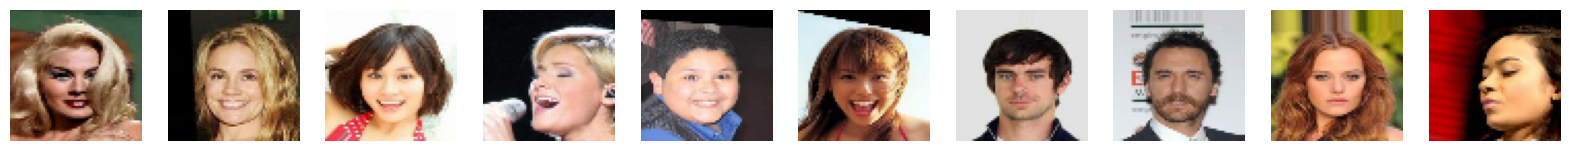

In [23]:
# 이미지 확인
train_sample = sample_batch(train)
display(train_sample,cmap=None)

In [24]:
# 변이형 오토인코더
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):  # 상속
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # 정규분포에서 셈플링

In [26]:
# 인코더
encoder_inputs = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
x = layers.Conv2D(NUM_FEATURES, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, 3,  strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, 3,  strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, 3,  strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, 3,  strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flatten = k.int_shape(x)[1:]

x = layers.Flatten()(x)
# flatten층을 잠재공간에 바로 연결안하고 z_mean, z_log_var층에 연결

z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # 샘플링
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

In [28]:
# 디코더
decorder_input = layers.Input(shape=(Z_DIM,))
x = layers.Dense(np.prod(shape_before_flatten))(decorder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(CHANNELS,(3,3),strides=1,activation='sigmoid', padding='same')(x)
decorder = models.Model(decorder_input,decoder_output)
decorder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               51456     
                                                                 
 batch_normalization_10 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 4, 4, 64)          36928     
 Transpose)                                                

In [29]:
#훈련 VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self,inputs): # 특정 입력 이미지에서 VAE를 호출했을때 반환값
      z_mean,z_log_var,z = encoder(inputs)
      reconstruction = decorder(z)
      return z_mean,z_log_var,reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [30]:
# 변이형 오토 인코더 생성
vae = VAE(encoder,decorder)

optimizer = optimizers.Adam(learning_rate = 0.0005)
vae.compile(optimizer=optimizer)

In [31]:
# 모델 저장 콜백함수
model_check_point = callbacks.ModelCheckpoint(
    filepath = './checkpoint',
    save_weights_only = False,
    save_freq = 'epoch',
    monitor = 'loss',
    mode = 'min',
    save_best_only = True,
    verbose =0
)
tensorboard_callback =  callbacks.TensorBoard(log_dir = './logs')

In [ ]:
vae.fit(
    train,
    epochs =EPOCHS,
    callbacks = [model_check_point,tensorboard_callback]
)

Epoch 1/10
   5/1583 [..............................] - ETA: 1:00:49 - total_loss: 1384.4978 - reconstruction_loss: 1384.4778 - kl_loss: 0.0202